In [54]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from PIL import Image

In [55]:
import os
from pathlib import Path

In [99]:
root = Path('data/')

processed_images_dir = root / 'processed_images'
raw_images_dir = root / 'raw_images'
control_images_dir = root / 'control_images'

In [100]:
os.listdir(processed_images_dir)

['A_EggTray_InHouse.jpg']

In [101]:
# control image
control_img_path = 'IMG_0529_с400-500_processed.jpg'
img = cv2.imread(control_images_dir / control_img_path)

There are two mechanistic methods.

Method 1: Suits pictures with lower resolution; works good with low contrast images.

Method 2: Works good with high-contrast images only.

### Method 1: Built-in contour detector

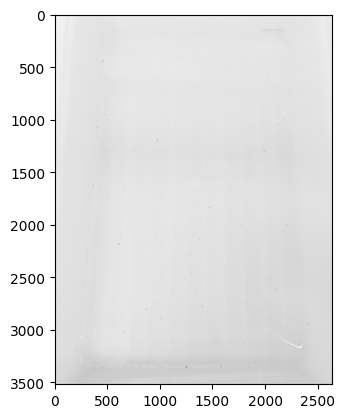

In [102]:
plt.imshow(img)

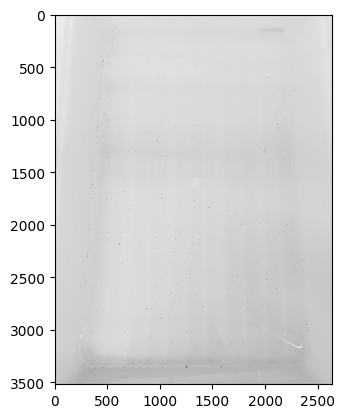

In [103]:
# make the image grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='grey')

In [104]:
brightness = 1
contrast = 1
img_enhanced = cv2.addWeighted(
    img,
    contrast,
    np.zeros(img.shape, img.dtype),
    0,
    brightness
)

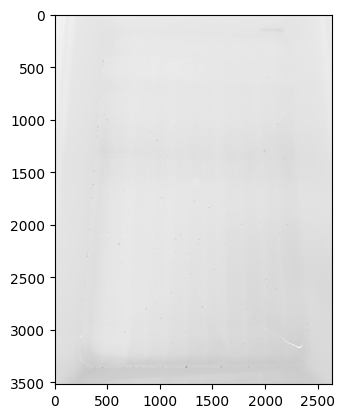

In [105]:
plt.imshow(img_enhanced);

In [158]:
# set threshold
th, threshed = cv2.threshold(
    img_gray, 100, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
)

# find contours of eggs
cnts = cv2.findContours(threshed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]

# filter by area
s1 = 40
s2 = 400 # 20 x 20 pixels bbox
xcnts = []
for cnt in cnts:
    if s1 < cv2.contourArea(cnt) < s2:
        xcnts.append(cnt)

print('Estimated eggs number: {}'.format(len(xcnts)))

Estimated eggs number: 490


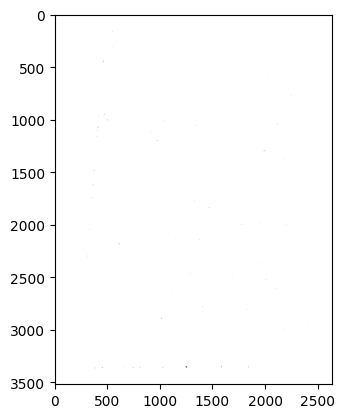

In [151]:
plt.imshow(thresh1, 'gray', vmin=0, vmax=255);

### Method 2: Hough circles

A quick circle detector, which uses a (Canny) edge detector to parse through the low-quality image and find circles of specified radius range.

In [169]:
img = cv2.imread(control_images_dir / control_img_path, 0)

# convert blurred grayscale image back to BGR
ret, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
 
# detect circles in the image using HoughCircles
# parameters:
# - img: the input image
# - cv2.HOUGH_GRADIENT: the detection method
# - 1: the inverse ratio of the accumulator resolution to the image resolution
# - 120: minimum distance between the centers of detected circles
# - param1: higher threshold for the Canny edge detector
# - param2: threshold for center detection
# - minRadius: minimum circle radius
# - maxRadius: maximum circle radius

circles = cv2.HoughCircles(
    img,
    cv2.HOUGH_GRADIENT,
    dp=2,
    minDist=5,
    param1=75,
    param2=2,
    minRadius=0,
    maxRadius=10
)

In [170]:
circles

array([[[1.247e+03, 3.357e+03, 6.600e+00],
        [1.001e+03, 2.893e+03, 8.800e+00],
        [9.690e+02, 1.203e+03, 4.400e+00],
        ...,
        [9.110e+02, 1.123e+03, 4.000e-01],
        [1.023e+03, 3.359e+03, 4.000e-01],
        [2.105e+03, 2.611e+03, 4.000e-01]]], dtype=float32)

In [171]:
# round circle parameters and convert to unsigned 16-bit integers
circles = np.uint16(np.around(circles))

In [172]:
print('Estimated eggs number: {}'.format(len(circles[0])))

Estimated eggs number: 422


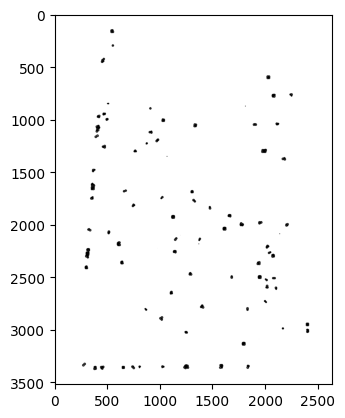

In [173]:
# loop through each detected circle
for i in circles[0, :]:
    # draw the outer circle
    # parameters:
    # - planets: the image to draw on
    # - (i[0], i[1]): the center coordinates of the circle
    # - i[2]: the radius of the circle
    # - (0, 255, 0): the color of the circle (green)
    # - 6: the thickness of the circle
    cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 6)
 
    # draw the center of the circle
    # parameters:
    # - planets: the image to draw on
    # - (i[0], i[1]): the center coordinates of the circle
    # - 2: the radius of the center point
    # - (0, 0, 255): the color of the center point (red)
    # - 3: the thickness of the center point
    cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)
 
# Display image with detected circles
plt.imshow(img, cmap='grey');

For reference, this is how image looked like before:

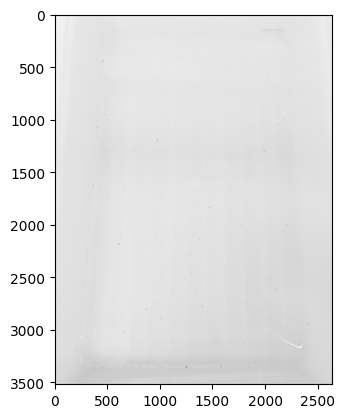

In [182]:
plt.imshow(cv2.imread(control_images_dir / control_img_path));